# Aggregate extraced time across multiple traces

1. Input parameters: directory with JSON traces, trace name pattern, (multiple) event patterns.  
   a. In trace name pattern, use one group for the varying parameter value (MBS).
2. For each event pattern, extract event time from all traces one by one using parseOneTrace script.
3. Aggregate values into one DF along with the varying parameter value extracted from the trace filename.


In [3]:
import os
import pandas as pd
import subprocess
import re
import matplotlib
from matplotlib import pyplot as plt

## Set input parameters

In [4]:
logdir = 'logs/P100.GCP.cont/traces/googlenet/20210413_8cpus_10K_100iter'
trace_name_pattern = 'nsys_trace_1_([0-1]+).json'
event_patterns = ['Iteration [123456789]+','.WD pass','.*Memcpy.*', 'Prediction and loss', 'Optimizer update']

## Read trace files

In [5]:
list_command = "ls -1 " + logdir
files = []
param_values = []
proc = subprocess.Popen(list_command.split(" "),
                        stdout=subprocess.PIPE,
                        stderr=subprocess.STDOUT,
                        encoding='utf8')
for line in iter(proc.stdout.readline, ''):
    line = line.strip(" \n")
    m = re.match(trace_name_pattern, line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir, line)))
        param_values.append(m.group(1))

print('{} files in {}'.format(len(files), logdir))
print(tuple(zip(files,param_values)))

2 files in logs/P100.GCP.cont/traces/googlenet/20210413_8cpus_10K_100iter
(('/HDD2/ML/nsystraceparser/logs/P100.GCP.cont/traces/googlenet/20210413_8cpus_10K_100iter/nsys_trace_1_1.json', '1'), ('/HDD2/ML/nsystraceparser/logs/P100.GCP.cont/traces/googlenet/20210413_8cpus_10K_100iter/nsys_trace_1_10.json', '10'))


In [38]:
results = None
convert_traces=True
for param, tracefile in zip(param_values, files):
    events = ' '.join(event_patterns)
    if convert_traces:
        # Run
        # python3 parseOneTrace.py -f $tracefile --events $events
        command = 'python3 parseOneTrace.py -f {} --events {}'.format(tracefile, events)
        print(command)
        p = subprocess.run(command.split(' '), stdin=subprocess.PIPE, stderr=subprocess.PIPE,
                           bufsize=0, shell=False)
        if p.returncode == 0:
            print('Finished OK')
        else:        
            print(p.stdout.decode('utf-8'))
            print('ERROR')
            print(p.stderr.decode('utf-8'))
    # Read data from CSV file
    directory = os.path.dirname(tracefile)
    csvfile = ('').join(os.path.basename(
        tracefile).split('.')[:-1])  # Filename without extension
    csvfile = csvfile + '.csv'
    csvfile = os.path.join(directory, csvfile)
    print('Reading {}'.format(csvfile))    
    df_ = pd.read_csv(csvfile)
    df_['param'] = param
#     display(df_.head())
    if results is None:
        results = df_
    else:
        results = results.append(df_, ignore_index=True)
        
results.sample(n=8)

python3 parseOneTrace.py -f /HDD2/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_10.json --events .WD pass .*Memcpy.* Prediction and loss Optimizer update
Finished OK
Reading /HDD2/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_10.csv
python3 parseOneTrace.py -f /HDD2/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_12.json --events .WD pass .*Memcpy.* Prediction and loss Optimizer update
Finished OK
Reading /HDD2/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_12.csv
python3 parseOneTrace.py -f /HDD2/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_15.json --events .WD pass .*Memcpy.* Prediction and loss Optimizer update
Finished OK
Reading /HDD2/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_15.csv
python3 parseOneTrace.py -f /HDD2/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_20.json --events .WD pass .*Memcpy.* Prediction and loss Optimizer update
Finished OK
Reading /HDD2/ML/nsystr

,name,NVTX,duration,GPU side,param
10893,cudaMemcpyAsync_v3020,"Iteration 1,Optimizer update",1.249000e-06,True,8
1640,cudaMemcpyAsync_v3020,Moving model to GPU,4.744000e-06,False,12
8188,cudaMemcpyAsync_v3020,Moving model to GPU,4.217000e-06,False,6
5365,cudaMemcpyAsync_v3020,Moving model to GPU,4.944100e-05,True,40
6563,cudaMemcpyAsync_v3020,Moving model to GPU,6.080000e-07,True,5
10109,cudaMemcpyAsync_v3020,Moving model to GPU,8.000000e-07,True,8
2166,cudaMemcpyAsync_v3020,Moving model to GPU,4.650000e-06,False,15
3905,cudaMemcpyAsync_v3020,"Iteration 1,Optimizer update",5.024000e-06,True,20


In [39]:
df_ = results.copy()
df_['NVTX'] = df_['NVTX'].fillna('')
# Do not use 1st and last iterations
print(df_['NVTX'].unique())
df_ = df_[(df_['NVTX'].str.contains('Iteration 3')) | (df_['NVTX'].str.contains('Iteration 4'))]
print(df_['NVTX'].unique())
print(df_['name'].unique())

['Moving model to GPU' 'Iteration 1' 'Iteration 1,FWD pass'
 'Iteration 1,BWD pass' 'Iteration 1,Optimizer update' 'Iteration 2'
 'Iteration 3' 'Iteration 4' 'Iteration 5' 'Iteration 6' '']
['Iteration 3' 'Iteration 4']
['cudaMemcpyAsync_v3020' 'FWD pass' 'Prediction and loss' 'BWD pass'
 'Optimizer update']


In [53]:
times = results.copy()
times['NVTX'] = times['NVTX'].fillna('')
# Use only iterations 3 and 4
times = times[(times['NVTX'].str.contains('Iteration 3')) | (times['NVTX'].str.contains('Iteration 4'))]
# Calculate aggregate time for FWD pass, loss, BWD pass and optupdate for GPU and CPU for each MBS
times = times[(times['name'].isin(['FWD pass', 'BWD pass','Prediction and loss','Optimizer update']))]
display(times.head())
times = times.groupby(['GPU side','param']).agg('sum').reset_index(drop=False)
times['param'] = times['param'].astype(int)
times = times.pivot(columns='param',values='duration',index='GPU side')
display(times.head())

times

,name,NVTX,duration,GPU side,param
1018,FWD pass,Iteration 3,0.012404,False,10
1019,FWD pass,Iteration 3,0.057031,True,10
1020,Prediction and loss,Iteration 3,0.000201,False,10
1021,Prediction and loss,Iteration 3,0.000044,True,10
1022,BWD pass,Iteration 3,0.012323,False,10


param,5,6,7,8,9,10,12,15,20,30,40
GPU side,,,,,,,,,,,
False,0.105219,0.104278,0.118307,0.133699,0.144110,0.155795,0.190166,0.215026,0.271205,0.408457,0.542200
True,0.254036,0.255808,0.286704,0.319290,0.348212,0.378376,0.449493,0.530019,0.685017,1.055548,1.390764


param,5,6,7,8,9,10,12,15,20,30,40
GPU side,,,,,,,,,,,
False,0.105219,0.104278,0.118307,0.133699,0.144110,0.155795,0.190166,0.215026,0.271205,0.408457,0.542200
True,0.254036,0.255808,0.286704,0.319290,0.348212,0.378376,0.449493,0.530019,0.685017,1.055548,1.390764


Text(0.5, 1.0, 'GPU and CPU time per iteration for logs/mouse.cont/traces/20200729')

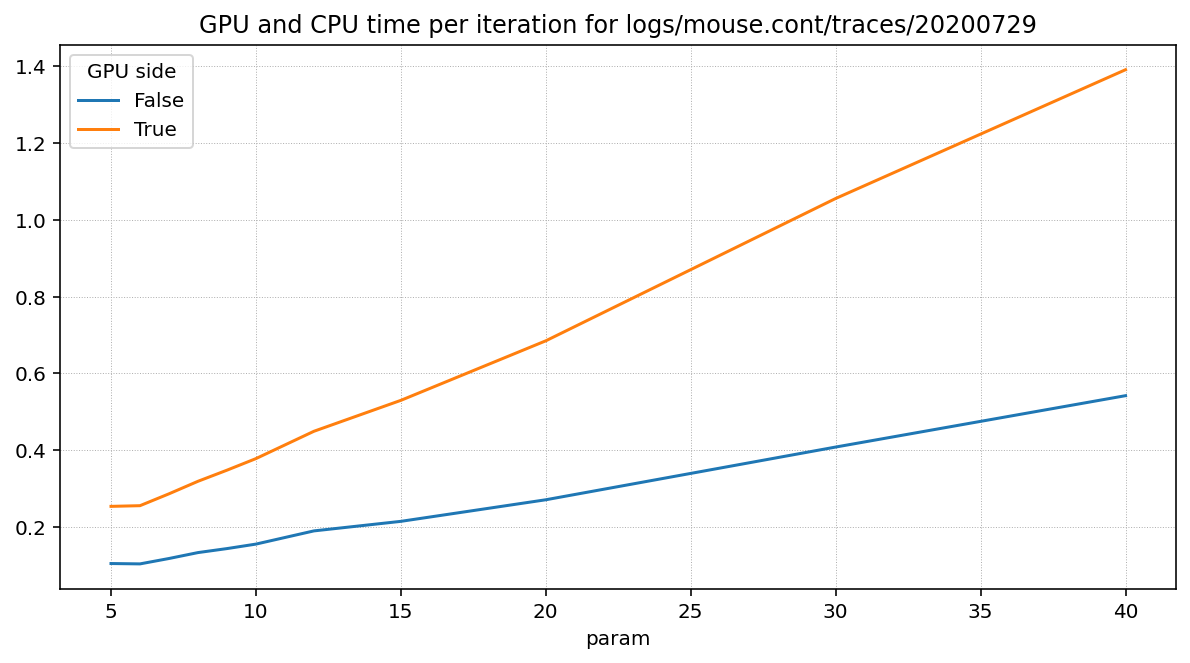

In [60]:
fig,ax = plt.subplots(figsize=(10,5),dpi=144)
ax = times.T.plot(ax=ax)
ax.grid(ls=':',lw=0.5)
ax.set_title("GPU and CPU time per iteration for {}".format(logdir))


### Older code (not relevant)

In [21]:
times = results.copy()
times['NVTX'] = times['NVTX'].fillna('')
times = times[(times['NVTX'].str.contains('Iteration 3')) | (times['NVTX'].str.contains('Iteration 4'))]
# Count duplicate entries
times_ = times.groupby(['NVTX', 'iteration', 'API event', 'param'], as_index=False).count()
display(times_[times_['duration'] > 1])
# No duplicates
# SUM time of the same API events in each iteration
times = times.groupby(['iteration', 'API event', 'param'], as_index=False).sum()
display(times.sample(n=5))
# Average between iterations
# Check number of entries
times_ = times.groupby(['API event', 'param'], as_index=False).count()
display(times_[times_['duration'] != 5])
# Have only one iteration for mbs50
times = times.groupby(['API event', 'param'], as_index=False).mean()
times['param'] = times['param'].astype(int)
display(times.head())

API events: ['cublasSgemmStridedBatched' 'cublasSgemm_v2'
 'cudnnBatchNormalizationBackwardEx' 'cudnnConvolutionBackwardData'
 'cudnnConvolutionBackwardFilter'
 'cudnnBatchNormalizationForwardTrainingEx' 'cudnnConvolutionForward']


,NVTX,iteration,API event,param,duration


,iteration,API event,param,duration
201,3,cudnnBatchNormalizationForwardTrainingEx,9,0.010554
337,5,cudnnBatchNormalizationBackwardEx,20,0.035016
296,4,cudnnConvolutionBackwardFilter,5,0.035000
131,2,cudnnConvolutionBackwardData,5,0.026901
177,3,cublasSgemm_v2,7,0.000417


,API event,param,iteration,duration
7,cublasSgemmStridedBatched,50,1,1
19,cublasSgemm_v2,50,1,1
42,cudnnBatchNormalizationForwardTrainingEx,50,1,1
76,cudnnConvolutionForward,50,1,1


,API event,param,iteration,duration
0,cublasSgemmStridedBatched,10,3,0.003134
1,cublasSgemmStridedBatched,12,3,0.003958
2,cublasSgemmStridedBatched,15,3,0.006116
3,cublasSgemmStridedBatched,20,3,0.007429
4,cublasSgemmStridedBatched,30,3,0.011677


API event,cublasSgemmStridedBatched,cublasSgemm_v2,cudnnBatchNormalizationBackwardEx,cudnnBatchNormalizationForwardTrainingEx,cudnnConvolutionBackwardData,cudnnConvolutionBackwardFilter,cudnnConvolutionForward
param,,,,,,,
12,0.003958,0.000453,0.020512,0.013845,0.049024,0.059015,0.047051
15,0.006116,0.000437,0.024218,0.015811,0.054204,0.066407,0.047926
20,0.007429,0.000448,0.035051,0.020764,0.070462,0.083770,0.060749
30,0.011677,0.000463,0.051631,0.033142,0.128869,0.118862,0.096147
40,0.018055,0.000663,0.069866,0.043725,0.174801,0.156511,0.140400


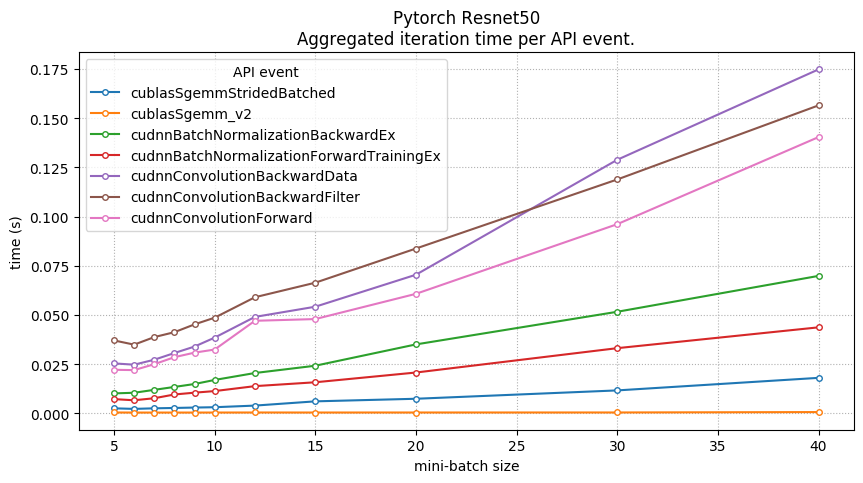

In [22]:
timesT = times.pivot_table(columns='API event', index='param', values='duration',aggfunc='sum')
# Use MBS 5-40
timesT = timesT.loc[:40]
display(timesT.tail())
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
timesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.grid(ls=':', which='major')
ax.grid(ls=':', lw=0.5, which='minor')
ax.set_xlabel('mini-batch size')
ax.set_ylabel('time (s)')
plt.title('Pytorch Resnet50\nAggregated iteration time per API event.')
plt.show()

In [16]:
# Group API events by type
def getType(e):
    types = {'FC': 'sgemm_v2',
             'conv': 'conv',
             'BN': 'batchnormalization'}
    for k, v in types.items():
        m = re.search(v, e.lower())
        if m is not None:
            return k
    return 'other'

In [17]:
# Sum time for same type events
times['type'] = times['API event'].apply(getType)
times = times[(times['type'] != 'other') & (times['param'] != 50)]
times = times.groupby(['type', 'param'], as_index=False).sum()
times['param'] = times['param'].astype(int)
times.head()
times.sample(n=7)

,type,param,iteration,duration
6,BN,12,6,0.034357
12,FC,6,3,0.000419
30,conv,20,9,0.214981
9,BN,30,6,0.084773
21,FC,40,3,0.000663
17,FC,12,3,0.000453
20,FC,30,3,0.000463


In [18]:
timesT = times.pivot_table(columns='type', index='param', values='duration')
timesT.head()

type,BN,FC,conv
param,,,
5,0.017407,0.000460,0.084629
6,0.017144,0.000419,0.081668
7,0.019659,0.000418,0.091030
8,0.023046,0.000419,0.100493
9,0.025450,0.000424,0.110049


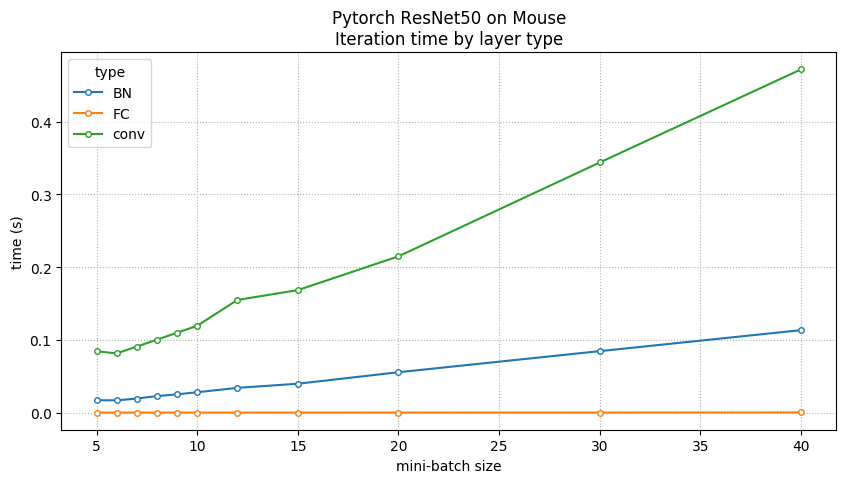

In [19]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
timesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.grid(ls=':', which='major')
ax.grid(ls=':', lw=0.5, which='minor')
ax.set_xlabel('mini-batch size')
ax.set_ylabel('time (s)')
plt.title('Pytorch ResNet50 on Mouse\nIteration time by layer type')
plt.show()